### Objetivo
Este notebook tem como objetivo realizar o pré-processamento dos dados para o desenvolvimento do modelo de credit scoring. As etapas incluem a separação temporal dos dados, o tratamento de valores ausentes, o tratamento de outliers, a análise de multicolinearidade, a avaliação do poder discriminatório das variáveis e a definição das bases finais para a etapa de modelagem.

In [1]:
import sys
import os

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT_DIR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from src.pre_processamento import imputacao
from src.pre_processamento import calcula_iv
from src.pre_processamento import transform_with_woe
from src.pre_processamento import fit_woe_binning
from src.pre_processamento import identifica_outliers_iqr


pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 80)
pd.set_option("display.float_format", "{:.4f}".format)

RANDOM_STATE = 42
DATA_PATH = "../data/raw/dataset.csv"

In [2]:
df = pd.read_csv(DATA_PATH)

#### #1 Ordenação temporal e split
A separação temporal dos dados foi adotada com o objetivo de evitar vazamento de informação e refletir o cenário real de concessão de crédito, garantindo que o modelo seja treinado exclusivamente com dados históricos e avaliado em dados futuros.

Para isso, a base foi ordenada temporalmente e dividida em três subconjuntos: treino, validação e teste, respeitando a sequência das safras.

In [3]:
df = df.sort_values('safra')

df_treino = df[df['safra'] <= 201406]
df_val   = df[(df['safra'] > 201406) & (df['safra'] <= 201409)]
df_teste  = df[df['safra'] > 201409]


#### #2 Tratamento de valores ausentes
Nesta etapa é realizado o tratamento dos valores ausentes presentes na base de dados. Inicialmente, foi definido um threshold de 40% para a taxa de valores ausentes, de forma que variáveis com proporção superior a esse limite foram removidas, visando reduzir ruído e instabilidade no modelo.

Para as variáveis remanescentes, foi aplicada imputação de valores ausentes.

In [4]:
features = df_treino.columns.tolist()

cols_to_remove = ['id', 'safra', 'y']
features = [col for col in features if col not in cols_to_remove]

In [5]:
missing_rate = df_treino.isnull().mean().sort_values(ascending=False)

high_missing_cols = missing_rate[missing_rate > 0.40].index.tolist()

df_treino = df_treino.drop(columns=high_missing_cols)
df_val   = df_val.drop(columns=high_missing_cols)
df_teste  = df_teste.drop(columns=high_missing_cols)

features = [col for col in features if col not in high_missing_cols]



In [6]:
# --- Treino ---
df_mediana = imputacao(df_treino, features, strategy='median')

# --- Referências do treino ---
medianas = df_mediana[features].median()

# --- Validação ---
df_validacao_mediana = imputacao(df_val, features, strategy='median', reference=medianas)

# --- Teste ---
df_teste_mediana = imputacao(df_teste, features, strategy='median', reference=medianas)


A escolha do método de imputação foi orientada por desempenho de modelo, comparando imputação pela média e pela mediana. A avaliação foi realizada a partir das métricas AUC, KS e Gini, sendo a imputação pela mediana a que apresentou melhor desempenho geral.

Resultados da comparação de imputação:

<font size="2">Mediana:<br>
AUC: 0.7007<br>
KS: 0.3147<br>
Gini: 0.4014<br>

Média<br>
AUC: 0.6982<br>
KS: 0.2972<br>
Gini: 0.3964<br></font>

#### #3 Tratamento de outliers
Nesta etapa é realizado o tratamento de variáveis com presença de outliers. Inicialmente, é aplicada uma análise baseada no intervalo interquartil (IQR) para identificar variáveis com valores extremos relevantes.

Para lidar com esse comportamento e aumentar a robustez do modelo, é aplicado o processo de binning seguido da transformação por Weight of Evidence (WoE). tratando outliers indiretamente, reduzindo sua influência sem perder informação preditiva e aumentando a estabilidade e interpretabilidade do modelo.


In [7]:
outliers_mediana = identifica_outliers_iqr(df_mediana, features, factor=1.5)
print(f"Mediana - Variáveis com outliers identificadas: {len(outliers_mediana)}")

Mediana - Variáveis com outliers identificadas: 20


In [8]:
# Calcular regras de WoE (Fit no Treino)
woe_maps_mediana = fit_woe_binning(df_mediana, outliers_mediana, target='y')

# Aplicar transformação (Transform no Treino, Validação e Teste)
df_mediana_tratada = transform_with_woe(df_mediana, woe_maps_mediana)
df_validacao_mediana_tratada = transform_with_woe(df_validacao_mediana, woe_maps_mediana)
df_teste_mediana_tratada = transform_with_woe(df_teste_mediana, woe_maps_mediana)

O tratamento descrito foi aplicado a 20 das 26 variáveis disponíveis. As variáveis que não apresentaram evidências relevantes de valores extremos foram mantidas em escala contínua, preservando a informação original dos dados.

#### #4 Análise discriminatória
A métrica Information Value (IV) é utilizada para avaliar a força discriminatória individual de cada variável preditora. Essa análise permite a eliminação de variáveis com baixo poder preditivo e também pode ser utilizada como critério auxiliar de desempate em etapas posteriores de análise de correlação.

O cálculo do IV é realizado exclusivamente sobre a base de treinamento, e os critérios definidos a partir dessa análise são posteriormente aplicados às bases de validação e teste, garantindo consistência e evitando vazamento de informação.

O IV é calculado de forma independente para cada variável, uma vez que seu objetivo nesta etapa é avaliar exclusivamente a capacidade discriminatória individual, e não o efeito conjunto das variáveis no modelo.



In [9]:
# Mediana
iv_values_mediana = {col: calcula_iv(df_mediana_tratada, col) for col in features}
iv_df_mediana = pd.DataFrame.from_dict(iv_values_mediana, orient='index', columns=['iv'])
iv_df_mediana = iv_df_mediana.sort_values('iv', ascending=False)

Com o IV calculado, são removidas do conjunto de variáveis aquelas que apresentam IV inferior a 0,02, indicando poder discriminatório muito baixo.

Em seguida, é realizada uma análise de multicolinearidade para identificar variáveis altamente correlacionadas entre si. Nos casos de alta correlação, a decisão de exclusão é baseada no valor de IV, mantendo-se a variável com maior poder discriminatório e removendo-se a redundante.

In [10]:
iv_df_mediana = iv_df_mediana[iv_df_mediana['iv'] >= 0.02]
features_mediana = iv_df_mediana.index.tolist()



As variáveis serão analisadas quanto à sua correlação por meio de uma matriz de correlação, permitindo a identificação de pares altamente correlacionados. Em seguida, serão tratados os casos em que a correlação absoluta entre variáveis seja maior ou igual a 0,85, aplicando os critérios definidos anteriormente para remoção de redundâncias.

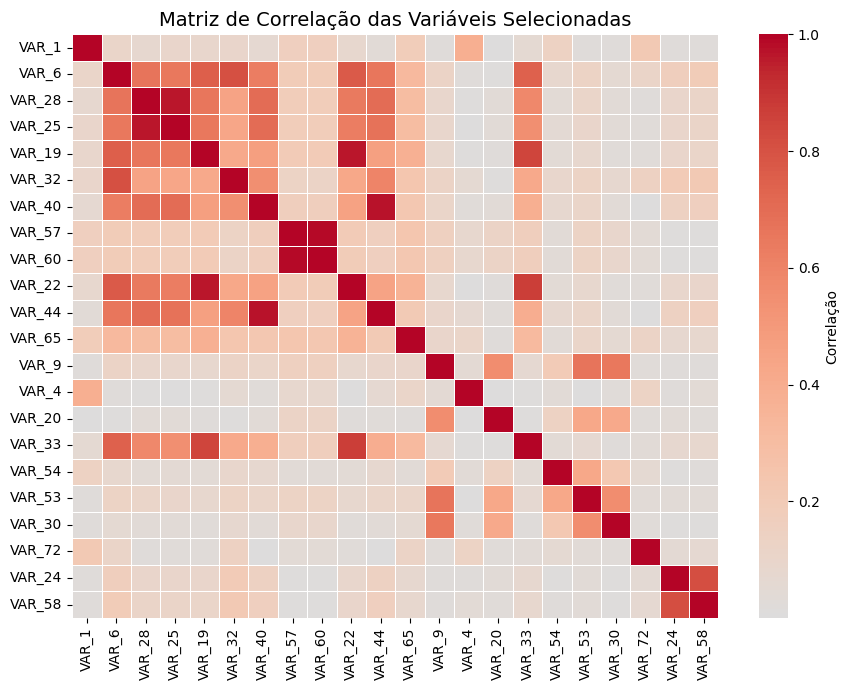

In [11]:
corr_mediana = df_mediana_tratada[features_mediana].corr().abs()

plt.figure(figsize=(9, 7))

sns.heatmap(
    corr_mediana,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Correlação'}
)

plt.title('Matriz de Correlação das Variáveis Selecionadas', fontsize=14)
plt.tight_layout()
plt.show()


Podemos observar uma alta correlação entre as variaveis:<br>
- Variaveis 57 e 60<br>
- Variaveis 40 e 44<br>
- Variaveis 25 e 28<br>
- Variaveis 19 e 22<br><br>

Para cada par altamente correlacionado, foi realizada a remoção da variável com menor Information Value (IV), mantendo-se aquela com maior poder discriminatório.

In [12]:
upper_mediana = corr_mediana.where(np.triu(np.ones(corr_mediana.shape), k=1).astype(bool))

to_drop_mediana = []

for col in upper_mediana.columns:
    high_corr = upper_mediana[col][upper_mediana[col] > 0.850].index.tolist()
    for row in high_corr:
        iv_col = iv_df_mediana.loc[col, 'iv']
        iv_row = iv_df_mediana.loc[row, 'iv']

        if iv_col >= iv_row:
            to_drop_mediana.append(row)
        else:
            to_drop_mediana.append(col)

to_drop_mediana = list(set(to_drop_mediana))


In [13]:
features_mediana = [col for col in features if col not in to_drop_mediana]

train_mediana = df_mediana_tratada[features_mediana + ['id', 'safra', 'y']].copy()
val_mediana = df_validacao_mediana_tratada[features_mediana + ['id', 'safra', 'y']].copy()
test_mediana = df_teste_mediana_tratada[features_mediana + ['id', 'safra', 'y']].copy()


#### #5 Salvamento de datasets pré-processados
Ao final do pré-processamento, os conjuntos de dados de treino, validação e teste são salvos de forma estruturada, garantindo reprodutibilidade do processo e consistência entre as etapas de desenvolvimento e modelagem. Esses datasets serão utilizados diretamente na fase de modelagem, sem a necessidade de reaplicação das etapas de tratamento.

In [14]:
# Treino
train_mediana.to_csv('../data/processed/treino_mediana.csv', index=False)


# Validação
val_mediana.to_csv('../data/processed/validacao_mediana.csv', index=False)


# Teste
test_mediana.to_csv('../data/processed/teste_mediana.csv', index=False)



#### #6 Considerações Finais - Pré-processamento

Nesta etapa do projeto foi desenvolvido todo o fluxo de pré-processamento, com foco em garantir a qualidade, consistência e estabilidade dos dados para a etapa de modelagem.

Inicialmente, os dados foram organizados por meio de uma separação temporal baseada na variável safra, respeitando a ordem cronológica do processo de concessão de crédito e evitando vazamento de informação entre os conjuntos de treino e períodos futuros.

Ao longo da análise, foram identificados pontos críticos que demandaram tratamento específico, dentre eles:<br>

- elevada taxa de valores ausentes;<br>
- baixa força discriminatória de algumas variáveis;<br>
- presença de multicolinearidade.<br>

Para o tratamento dos valores ausentes, foram removidas as variáveis que apresentavam mais de 40% de valores nulos. Em seguida, algumas variáveis selecionadas passaram por processo de binning seguido da transformação por Weight of Evidence (WoE). Posteriormente, foram avaliadas duas estratégias de imputação para as variáveis remanescentes: imputação pela mediana e imputação pela média. A escolha final pela imputação por mediana foi baseada na comparação do desempenho do modelo, que apresentou melhores métricas de AUC, KS e Gini.

A seleção das variáveis quanto à sua força discriminatória foi realizada por meio da métrica Information Value (IV), amplamente utilizada em modelos de risco de crédito por sua capacidade de mensurar o poder preditivo individual das variáveis a partir do conceito de Weight of Evidence (WoE).

Posteriormente, foi avaliada a matriz de correlação entre as variáveis selecionadas. Nos casos de multicolinearidade com correlação superior a 85%, o IV foi utilizado como critério de desempate, mantendo-se sempre a variável com maior poder discriminatório.

Como resultado, obteve-se um conjunto de variáveis estatisticamente relevantes, com menor redundância e adequadamente preparado para a etapa de modelagem.